In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import datetime 
import pandas as pd
import os
import sqlite3
from sqlite3 import Error
from sqlalchemy import create_engine
from sklearn.cluster import KMeans

In [2]:
# Re-load the datasets after execution state reset
superstore_file_path = "Sample-Superstore.csv"

# Read the datasets
superstore_df = pd.read_csv(superstore_file_path, encoding="ISO-8859-1")


# Ensure numerical columns are correctly interpreted for superstore data
numeric_columns = ["Sales", "Profit", "Discount", "Quantity"]
for col in numeric_columns:
    if col in superstore_df.columns:
        superstore_df[col] = pd.to_numeric(superstore_df[col], errors="coerce")

# 1) Add calculated columns to Sample-Superstore
superstore_df["Estimated Cost"] = superstore_df["Sales"] - (superstore_df["Profit"] + (superstore_df["Sales"] * superstore_df["Discount"]))
superstore_df["Estimated Cost p/unit"] = superstore_df["Estimated Cost"] / superstore_df["Quantity"]
superstore_df["Estimated Sale Price p/unit"] = superstore_df["Sales"] / superstore_df["Quantity"]
superstore_df["Estimated Profit p/unit"] = superstore_df["Estimated Sale Price p/unit"] - superstore_df["Estimated Cost p/unit"]
superstore_df["Estimated Profit Margin p/unit"] = superstore_df["Estimated Profit p/unit"] / superstore_df["Estimated Sale Price p/unit"]

# 2) Add projected profit adjustments and pricing corrections
# Define the minimum projected profit margin requirement
minimum_profit_margin = 0.10  # 10%

# Initialize adjusted discount column
superstore_df["Adjusted Discount"] = superstore_df["Discount"]

# Cases where applying a discount reduction can achieve 10% profit margin
profit_target_sales = superstore_df["Estimated Cost"] / (1 - minimum_profit_margin)
superstore_df["Adjusted Discount"] = 1 - (profit_target_sales / superstore_df["Sales"])

# Ensure the adjusted discount is not negative (meaning no discount applied if it's already profitable)
superstore_df["Adjusted Discount"] = superstore_df["Adjusted Discount"].clip(lower=0)

# Identify cases where discount adjustment alone is not enough (price adjustment needed)
needs_price_adjustment = superstore_df["Estimated Profit Margin p/unit"] < 0.1

# Assign actions based on whether discount or price needs adjusting
superstore_df["Action"] = "Adjust Discount"
superstore_df.loc[needs_price_adjustment, "Action"] = "Adjust Price"

# Adjust Sale Price Per Unit to meet the 10% profit margin requirement
superstore_df.loc[needs_price_adjustment, "Adjusted Sale Price p/unit"] = superstore_df["Estimated Cost p/unit"] / (1 - minimum_profit_margin)

# Ensure adjusted sale price is only changed for "Adjust Price" cases
superstore_df["Adjusted Sale Price p/unit"].fillna(superstore_df["Estimated Sale Price p/unit"], inplace=True)

# Recalculate projected profit per unit for adjusted prices
superstore_df["Projected Profit p/unit"] = superstore_df["Adjusted Sale Price p/unit"] - superstore_df["Estimated Cost p/unit"]

# Calculate the required discount to achieve the minimum projected profit margin
superstore_df["Projected Profit Margin"] = superstore_df["Projected Profit p/unit"] / superstore_df["Adjusted Sale Price p/unit"]

# Recalculate projected total profit for adjusted prices
superstore_df["Projected total profit"] = (superstore_df["Adjusted Sale Price p/unit"] * superstore_df["Quantity"]) - superstore_df["Estimated Cost"]

# Calculate projected sales based on adjusted pricing
superstore_df["Projected Sales"] = superstore_df["Adjusted Sale Price p/unit"] * superstore_df["Quantity"]




/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_1640/3026991110.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  superstore_df["Adjusted Sale Price p/unit"].fillna(superstore_df["Estimated Sale Price p/unit"], inplace=True)


In [3]:
negative_profit_transactions = superstore_df[superstore_df["Profit"]<0.1]
negative_profit_transactions

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Estimated Sale Price p/unit,Estimated Profit p/unit,Estimated Profit Margin p/unit,Adjusted Discount,Action,Adjusted Sale Price p/unit,Projected Profit p/unit,Projected Profit Margin,Projected total profit,Projected Sales
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,191.5155,9.575775,0.050000,0.000000,Adjust Price,202.155250,20.215525,0.100000,101.077625,1010.776250
14,15,US-2015-118983,11/22/2015,11/26/2015,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,...,13.7620,-13.762000,-1.000000,0.000000,Adjust Price,30.582222,3.058222,0.100000,15.291111,152.911111
15,16,US-2015-118983,11/22/2015,11/26/2015,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,...,0.8480,-0.593600,-0.700000,0.000000,Adjust Price,1.601778,0.160178,0.100000,0.480533,4.805333
23,24,US-2017-156909,7/16/2017,7/18/2017,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,...,35.6860,10.196000,0.285714,0.206349,Adjust Discount,35.686000,10.196000,0.285714,20.392000,71.372000
27,28,US-2015-150630,9/17/2015,9/21/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,440.4900,-17.619600,-0.040000,0.000000,Adjust Price,509.010667,50.901067,0.100000,356.307467,3563.074667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9921,9922,CA-2014-111360,11/24/2014,11/30/2014,Standard Class,AT-10435,Alyssa Tate,Home Office,United States,Akron,...,1.9140,-0.191400,-0.100000,0.000000,Adjust Price,2.339333,0.233933,0.100000,0.701800,7.018000
9931,9932,CA-2015-104948,11/13/2015,11/17/2015,Standard Class,KH-16510,Keith Herrera,Consumer,United States,San Bernardino,...,170.8330,15.575950,0.091176,0.000000,Adjust Price,172.507833,17.250783,0.100000,69.003133,690.031333
9937,9938,CA-2016-164889,6/3/2016,6/6/2016,Second Class,CP-12340,Christine Phan,Corporate,United States,Los Angeles,...,35.5440,6.220200,0.175000,0.083333,Adjust Discount,35.544000,6.220200,0.175000,12.440400,71.088000
9962,9963,CA-2015-168088,3/19/2015,3/22/2015,First Class,CM-12655,Corinna Mitchell,Home Office,United States,Houston,...,95.8664,13.759648,0.143529,0.048366,Adjust Discount,95.866400,13.759648,0.143529,55.038592,383.465600


In [4]:
negative_profit_transactions.groupby("Action").size()

Action
Adjust Discount     550
Adjust Price       1389
dtype: int64

In [5]:
# Recalculate the "Action" column to correctly account for cases where reducing the discount achieves a 10% total profit margin

# Define the minimum projected profit margin requirement
minimum_profit_margin = 0.10  # 10%

# Recalculate profit target sales to achieve a 10% **total** profit margin
profit_target_sales_total = superstore_df["Estimated Cost"] / (1 - minimum_profit_margin)

# Determine cases where reducing discount would be enough to meet the required total profit margin
adjust_discount_needed = (1 - (profit_target_sales_total / superstore_df["Sales"])) < superstore_df["Discount"]

# Identify cases where price adjustment is still needed
needs_price_adjustment = ~adjust_discount_needed & (superstore_df["Estimated Profit Margin p/unit"] < 0.1)

# Assign "Adjust Discount" where reducing the discount is sufficient
superstore_df["Action"] = "No Action Needed"
superstore_df.loc[adjust_discount_needed, "Action"] = "Adjust Discount"
superstore_df.loc[needs_price_adjustment, "Action"] = "Adjust Price"

# Adjust the discount for the cases where discount reduction is needed
superstore_df.loc[adjust_discount_needed, "Adjusted Discount"] = 1 - (profit_target_sales_total / superstore_df["Sales"])

# Ensure the adjusted discount is not negative
superstore_df["Adjusted Discount"] = superstore_df["Adjusted Discount"].clip(lower=0)

# Adjust Sale Price Per Unit only where necessary
superstore_df.loc[needs_price_adjustment, "Adjusted Sale Price p/unit"] = superstore_df["Estimated Cost p/unit"] / (1 - minimum_profit_margin)

# Ensure adjusted sale price is only changed for "Adjust Price" cases
superstore_df["Adjusted Sale Price p/unit"].fillna(superstore_df["Estimated Sale Price p/unit"], inplace=True)

# Recalculate projected profit per unit for adjusted prices
superstore_df["Projected Profit p/unit"] = superstore_df["Adjusted Sale Price p/unit"] - superstore_df["Estimated Cost p/unit"]

# Calculate the required discount to achieve the minimum projected profit margin
superstore_df["Projected Profit Margin"] = superstore_df["Projected Profit p/unit"] / superstore_df["Adjusted Sale Price p/unit"]

# Recalculate projected total profit for adjusted prices
superstore_df["Projected total profit"] = (superstore_df["Adjusted Sale Price p/unit"] * superstore_df["Quantity"]) - superstore_df["Estimated Cost"]

# Calculate projected sales based on adjusted pricing
superstore_df["Projected Sales"] = superstore_df["Adjusted Sale Price p/unit"] * superstore_df["Quantity"]



/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_1640/2106287047.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  superstore_df["Adjusted Sale Price p/unit"].fillna(superstore_df["Estimated Sale Price p/unit"], inplace=True)


In [6]:
superstore_df["Transaction Profit Margin"] = superstore_df ["Profit"]/ superstore_df["Sales"]

In [7]:
superstore_df = superstore_df[['Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit','Transaction Profit Margin',
       'Estimated Cost', 'Estimated Cost p/unit',
       'Estimated Sale Price p/unit', 'Estimated Profit p/unit',
       'Estimated Profit Margin p/unit', 'Adjusted Discount', 'Action',
       'Adjusted Sale Price p/unit', 'Projected Profit p/unit',
       'Projected Profit Margin', 'Projected total profit', 'Projected Sales',
       ]]

In [8]:
superstore_df.to_csv("superstore_update.csv")


In [9]:
#TODO - check discount of same items in different states
# do another kpi for sale price

In [10]:


# # Ensure numerical columns are correctly interpreted
# numeric_columns = ["Sales", "Quantity"]
# for col in numeric_columns:
#     if col in superstore_df.columns:
#         superstore_df[col] = pd.to_numeric(superstore_df[col], errors="coerce")

# Convert "Order Date" to datetime format if available
if "Order Date" in superstore_df.columns:
    superstore_df["Order Date"] = pd.to_datetime(superstore_df["Order Date"], errors="coerce")
    superstore_df["Year-Month"] = superstore_df["Order Date"].dt.to_period("M")

# Group data by Year-Month and calculate Price per Unit
price_per_unit_kpi = superstore_df.groupby("Year-Month").agg(
    Total_Sales=("Sales", "sum"),
    Total_Quantity=("Quantity", "sum")
).reset_index()

# Calculate Price per Unit
price_per_unit_kpi["Price per Unit"] = price_per_unit_kpi["Total_Sales"] / price_per_unit_kpi["Total_Quantity"]




In [11]:
price_per_unit_kpi.head()

,Year-Month,Total_Sales,Total_Quantity,Price per Unit
0,2014-01,14236.895,284,50.129912
1,2014-02,4519.892,159,28.426994
2,2014-03,55691.009,585,95.198306
3,2014-04,28295.345,536,52.789823
4,2014-05,23648.287,466,50.747397


# checking profit margin by subcategory

In [12]:
# 1) Profitability Breakdown Within Furniture
furniture_df = superstore_df[superstore_df["Category"] == "Furniture"]

# Aggregate profit margin by sub-category
furniture_subcategory_profit = furniture_df.groupby("Sub-Category").agg(
    {"Sales": "sum", "Profit": "sum", "Discount": "mean"}
).reset_index()

# Calculate profit margin percentage
furniture_subcategory_profit["Profit Margin (%)"] = (furniture_subcategory_profit["Profit"] / furniture_subcategory_profit["Sales"]) * 100


furniture_subcategory_profit

,Sub-Category,Sales,Profit,Discount,Profit Margin (%)
0,Bookcases,114879.9963,-3472.5560,0.211140,-3.022768
1,Chairs,328449.1030,26590.1663,0.170178,8.095673
2,Furnishings,91705.1640,13059.1436,0.138349,14.240358
3,Tables,206965.5320,-17725.4811,0.261285,-8.564460


In [13]:
technology_df = superstore_df[superstore_df["Category"] == "Technology"]
technology_discount_correlation = technology_df[["Transaction Profit Margin", "Discount"]].corr().iloc[0, 1]


In [14]:
# Aggregate profit margin by sub-category
technology_subcategory_profit = technology_df.groupby("Sub-Category").agg(
    {"Sales": "sum", "Profit": "sum", "Discount": "mean"}
).reset_index()

# Calculate profit margin percentage
technology_subcategory_profit["Profit Margin (%)"] = (technology_subcategory_profit["Profit"] / technology_subcategory_profit["Sales"]) * 100

In [15]:
technology_subcategory_profit

,Sub-Category,Sales,Profit,Discount,Profit Margin (%)
0,Accessories,167380.318,41936.6357,0.078452,25.054700
1,Copiers,149528.030,55617.8249,0.161765,37.195585
2,Machines,189238.631,3384.7569,0.306087,1.788618
3,Phones,330007.054,44515.7306,0.154556,13.489327


In [16]:
technology_discount_correlation

np.float64(-0.7551586032184515)

In [17]:
office_supplies_df = superstore_df[superstore_df["Category"] == "Office Supplies"]
office_supplies_discount_correlation = office_supplies_df[["Transaction Profit Margin", "Discount"]].corr().iloc[0, 1]
office_supplies_discount_correlation

np.float64(-0.8772941598235355)

In [18]:
# Aggregate profit margin by sub-category
office_supplies_subcategory_profit = office_supplies_df.groupby("Sub-Category").agg(
    {"Sales": "sum", "Profit": "sum", "Discount": "mean"}
).reset_index()

# Calculate profit margin percentage
office_supplies_subcategory_profit["Profit Margin (%)"] = (office_supplies_subcategory_profit["Profit"] / office_supplies_subcategory_profit["Sales"]) * 100

In [19]:
office_supplies_subcategory_profit

,Sub-Category,Sales,Profit,Discount,Profit Margin (%)
0,Appliances,107532.161,18138.0054,0.166524,16.867517
1,Art,27118.792,6527.7870,0.074874,24.071083
2,Binders,203412.733,30221.7633,0.372292,14.857361
3,Envelopes,16476.402,6964.1767,0.080315,42.267582
4,Fasteners,3024.280,949.5182,0.082028,31.396504
5,Labels,12486.312,5546.2540,0.068681,44.418672
6,Paper,78479.206,34053.5693,0.074891,43.391837
7,Storage,223843.608,21278.8264,0.074704,9.506113
8,Supplies,46673.538,-1189.0995,0.076842,-2.547695


In [20]:
# profit by state
profit_by_state = superstore_df.groupby("State")["Profit"].sum()

In [21]:
profit_by_state

State
Alabama                  5786.8253
Arizona                 -3427.9246
Arkansas                 4008.6871
California              76381.3871
Colorado                -6527.8579
Connecticut              3511.4918
Delaware                 9977.3748
District of Columbia     1059.5893
Florida                 -3399.3017
Georgia                 16250.0433
Idaho                     826.7231
Illinois               -12607.8870
Indiana                 18382.9363
Iowa                     1183.8119
Kansas                    836.4435
Kentucky                11199.6966
Louisiana                2196.1023
Maine                     454.4862
Maryland                 7031.1788
Massachusetts            6785.5016
Michigan                24463.1876
Minnesota               10823.1874
Mississippi              3172.9762
Missouri                 6436.2105
Montana                  1833.3285
Nebraska                 2037.0942
Nevada                   3316.7659
New Hampshire            1706.5028
New Jersey    

In [22]:
# discount by category
# Aggregate profit margin by sub-category
category_profit = superstore_df.groupby("Category").agg(
    {"Sales": "sum", "Profit": "sum", "Discount": "mean","Estimated Cost p/unit": "mean" }
).reset_index()

# Calculate profit margin percentage
category_profit["Profit Margin (%)"] = (category_profit["Profit"] / category_profit["Sales"]) * 100

In [23]:
category_profit

,Category,Sales,Profit,Discount,Estimated Cost p/unit,Profit Margin (%)
0,Furniture,741999.7953,18451.2728,0.173923,73.433070,2.486695
1,Office Supplies,719047.0320,122490.8008,0.157285,23.005348,17.035158
2,Technology,836154.0330,145454.9481,0.132323,81.793887,17.395712


Discount has a big impact on profit margins, but is not the only factor. High costs p/unit in conjunction with exagerated discounts seems to provide a better explanation. 

In [24]:
# COGS by subcatgory

# Ensure numerical columns are correctly interpreted
numeric_columns = ["Sales", "Estimated Cost"]
for col in numeric_columns:
    if col in superstore_df.columns:
        superstore_df[col] = pd.to_numeric(superstore_df[col], errors="coerce")

# 1️⃣ **Calculate COGS as a Percentage of Sales**
superstore_df["COGS %"] = (superstore_df["Estimated Cost"] / superstore_df["Sales"]) * 100

# 2️⃣ **Aggregate COGS % by Category & Sub-Category**
cogs_percentage_df = superstore_df.groupby(["Category", "Sub-Category"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Estimated_Cost=("Estimated Cost", "sum")
).reset_index()

# Calculate COGS % for each Category & Sub-Category
cogs_percentage_df["COGS %"] = (cogs_percentage_df["Total_Estimated_Cost"] / cogs_percentage_df["Total_Sales"]) * 100

cogs_percentage_df

,Category,Sub-Category,Total_Sales,Total_Estimated_Cost,COGS %
0,Furniture,Bookcases,114879.9963,97551.961259,84.916404
1,Furniture,Chairs,328449.1030,252044.136600,76.737654
2,Furniture,Furnishings,91705.1640,69937.067600,76.262955
3,Furniture,Tables,206965.5320,180498.816000,87.212018
4,Office Supplies,Appliances,107532.1610,81903.855900,76.166846
5,Office Supplies,Art,27118.7920,18770.174600,69.214641
6,Office Supplies,Binders,203412.7330,129445.890400,63.637064
7,Office Supplies,Envelopes,16476.4020,8338.234900,50.607134
8,Office Supplies,Fasteners,3024.2800,1834.473800,60.658200
9,Office Supplies,Labels,12486.3120,6290.707600,50.380830


In [25]:
# 2️⃣ **Aggregate COGS % by Category & Sub-Category**
cogs_percentage_df_category = superstore_df.groupby(["Category"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Estimated_Cost=("Estimated Cost", "sum")
).reset_index()

cogs_percentage_df_category["COGS %"] = (cogs_percentage_df_category["Total_Estimated_Cost"] / cogs_percentage_df_category["Total_Sales"]) * 100

cogs_percentage_df_category

,Category,Total_Sales,Total_Estimated_Cost,COGS %
0,Furniture,741999.7953,600031.981459,80.866866
1,Office Supplies,719047.0320,520151.290600,72.338980
2,Technology,836154.0330,568038.432200,67.934664


In [26]:
# COGS PER YEAR
# Ensure numerical columns are correctly interpreted
numeric_columns = ["Sales", "Estimated Cost"]
for col in numeric_columns:
    if col in superstore_df.columns:
        superstore_df[col] = pd.to_numeric(superstore_df[col], errors="coerce")

# Convert "Order Date" to datetime format if available
if "Order Date" in superstore_df.columns:
    superstore_df["Order Date"] = pd.to_datetime(superstore_df["Order Date"], errors="coerce")
    superstore_df["Year"] = superstore_df["Order Date"].dt.year

# Calculate COGS per year
cogs_per_year = superstore_df.groupby("Year").agg(
    Total_Sales=("Sales", "sum"),
    Total_Estimated_Cost=("Estimated Cost", "sum")
).reset_index()

# Calculate COGS % per year
cogs_per_year["COGS %"] = (cogs_per_year["Total_Estimated_Cost"] / cogs_per_year["Total_Sales"]) * 100
cogs_per_year

,Year,Total_Sales,Total_Estimated_Cost,COGS %
0,2014,484247.4981,357146.728613,73.752932
1,2015,470532.5090,346052.719960,73.544912
2,2016,609205.5980,446498.856820,73.291982
3,2017,733215.2552,538523.398866,73.446835


## Revenue Profit impact analysis (all categories)

In [27]:
# Calculate original total revenue
original_revenue = superstore_df["Sales"].sum()

# Calculate projected total revenue after adjustments
superstore_df["Projected Sales"] = superstore_df["Adjusted Sale Price p/unit"] * superstore_df["Quantity"]
projected_revenue = superstore_df["Projected Sales"].sum()

# Calculate the percentage change in revenue
revenue_change_percentage = ((projected_revenue - original_revenue) / original_revenue) * 100

# Calculate total profit change
original_total_profit = superstore_df["Profit"].sum()
projected_total_profit = superstore_df["Projected total profit"].sum()
profit_change_percentage = ((projected_total_profit - original_total_profit) / original_total_profit) * 100

# Create a summary of the revenue and profit impact
revenue_impact_summary = pd.DataFrame({
    "Metric": ["Original Revenue", "Projected Revenue", "Revenue Change (%)", "Original Total Profit", "Projected Total Profit", "Profit Change (%)"],
    "Value": [original_revenue, projected_revenue, revenue_change_percentage, original_total_profit, projected_total_profit, profit_change_percentage]
})


In [28]:
revenue_impact_summary

,Metric,Value
0,Original Revenue,2.297201e+06
1,Projected Revenue,2.365142e+06
2,Revenue Change (%),2.957541e+00
3,Original Total Profit,2.863970e+05
4,Projected Total Profit,6.769198e+05
5,Profit Change (%),1.363571e+02


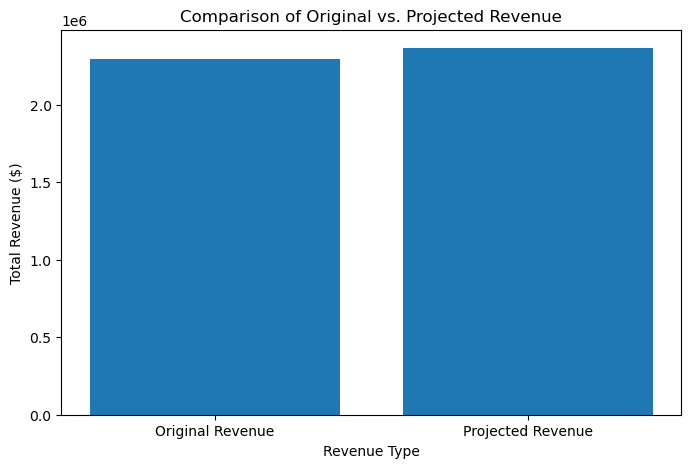

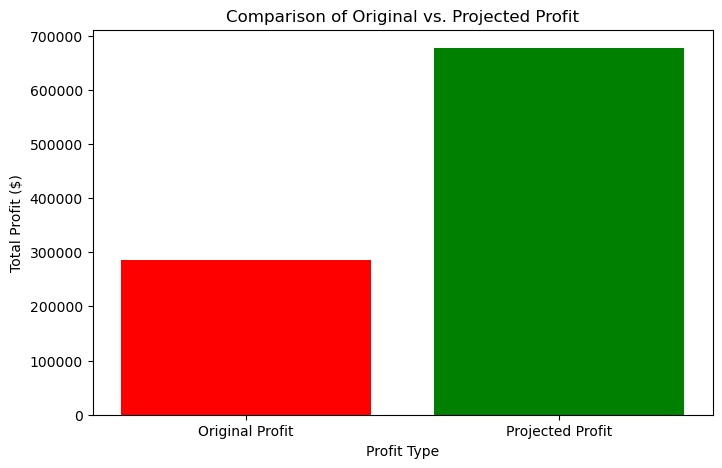

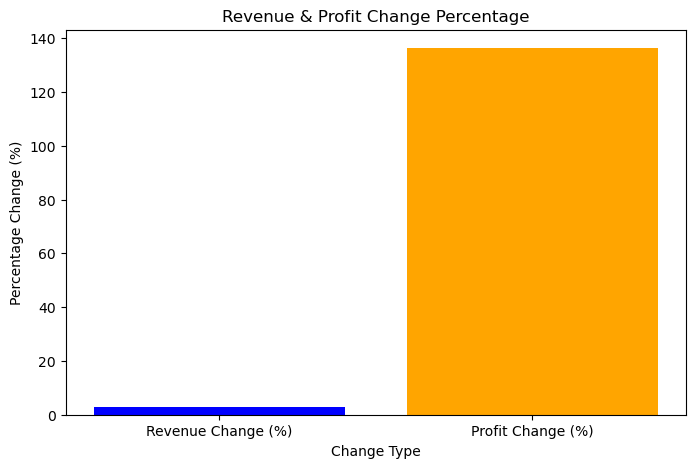

In [29]:
import matplotlib.pyplot as plt

# Creating a bar chart for revenue comparison
plt.figure(figsize=(8, 5))
plt.bar(["Original Revenue", "Projected Revenue"], [original_revenue, projected_revenue])
plt.xlabel("Revenue Type")
plt.ylabel("Total Revenue ($)")
plt.title("Comparison of Original vs. Projected Revenue")
plt.show()

# Creating a bar chart for profit comparison
plt.figure(figsize=(8, 5))
plt.bar(["Original Profit", "Projected Profit"], [original_total_profit, projected_total_profit], color=["red", "green"])
plt.xlabel("Profit Type")
plt.ylabel("Total Profit ($)")
plt.title("Comparison of Original vs. Projected Profit")
plt.show()

# Creating a bar chart for percentage change in revenue and profit
plt.figure(figsize=(8, 5))
plt.bar(["Revenue Change (%)", "Profit Change (%)"], [revenue_change_percentage, profit_change_percentage], color=["blue", "orange"])
plt.xlabel("Change Type")
plt.ylabel("Percentage Change (%)")
plt.title("Revenue & Profit Change Percentage")
plt.show()

In [30]:
## Revenue Profit impact analysis (per categories)

In [31]:
#furniture 
original_revenue = furniture_df["Sales"].sum()

# Calculate projected total revenue after adjustments
furniture_df["Projected Sales"] = furniture_df["Adjusted Sale Price p/unit"] * furniture_df["Quantity"]
projected_revenue = furniture_df["Projected Sales"].sum()

# Calculate the percentage change in revenue
revenue_change_percentage = ((projected_revenue - original_revenue) / original_revenue) * 100

# Calculate total profit change
original_total_profit = furniture_df["Profit"].sum()
projected_total_profit = furniture_df["Projected total profit"].sum()
profit_change_percentage = ((projected_total_profit - original_total_profit) / original_total_profit) * 100

# Create a summary of the revenue and profit impact
revenue_impact_summary_furniture = pd.DataFrame({
    "Metric": ["Original Revenue", "Projected Revenue", "Revenue Change (%)", "Original Total Profit", "Projected Total Profit", "Profit Change (%)"],
    "Value": [original_revenue, projected_revenue, revenue_change_percentage, original_total_profit, projected_total_profit, profit_change_percentage]
})

/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_1640/38907708.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture_df["Projected Sales"] = furniture_df["Adjusted Sale Price p/unit"] * furniture_df["Quantity"]


In [32]:
revenue_impact_summary_furniture

,Metric,Value
0,Original Revenue,741999.795300
1,Projected Revenue,760703.945351
2,Revenue Change (%),2.520776
3,Original Total Profit,18451.272800
4,Projected Total Profit,160671.963892
5,Profit Change (%),770.790680


In [33]:
#office supplies
original_revenue = office_supplies_df["Sales"].sum()

# Calculate projected total revenue after adjustments
office_supplies_df["Projected Sales"] = office_supplies_df["Adjusted Sale Price p/unit"] * office_supplies_df["Quantity"]
projected_revenue = office_supplies_df["Projected Sales"].sum()

# Calculate the percentage change in revenue
revenue_change_percentage = ((projected_revenue - original_revenue) / original_revenue) * 100

# Calculate total profit change
original_total_profit = office_supplies_df["Profit"].sum()
projected_total_profit = office_supplies_df["Projected total profit"].sum()
profit_change_percentage = ((projected_total_profit - original_total_profit) / original_total_profit) * 100

# Create a summary of the revenue and profit impact
revenue_impact_summary_office_supplies = pd.DataFrame({
    "Metric": ["Original Revenue", "Projected Revenue", "Revenue Change (%)", "Original Total Profit", "Projected Total Profit", "Profit Change (%)"],
    "Value": [original_revenue, projected_revenue, revenue_change_percentage, original_total_profit, projected_total_profit, profit_change_percentage]
})

/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_1640/3119356572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  office_supplies_df["Projected Sales"] = office_supplies_df["Adjusted Sale Price p/unit"] * office_supplies_df["Quantity"]


In [34]:
revenue_impact_summary_office_supplies

,Metric,Value
0,Original Revenue,719047.032000
1,Projected Revenue,754950.232556
2,Revenue Change (%),4.993164
3,Original Total Profit,122490.800800
4,Projected Total Profit,234798.941956
5,Profit Change (%),91.687001


In [35]:
#technology
original_revenue = technology_df["Sales"].sum()

# Calculate projected total revenue after adjustments
technology_df["Projected Sales"] = technology_df["Adjusted Sale Price p/unit"] * technology_df["Quantity"]
projected_revenue = technology_df["Projected Sales"].sum()

# Calculate the percentage change in revenue
revenue_change_percentage = ((projected_revenue - original_revenue) / original_revenue) * 100

# Calculate total profit change
original_total_profit = technology_df["Profit"].sum()
projected_total_profit = technology_df["Projected total profit"].sum()
profit_change_percentage = ((projected_total_profit - original_total_profit) / original_total_profit) * 100

# Create a summary of the revenue and profit impact
revenue_impact_summary_technology = pd.DataFrame({
    "Metric": ["Original Revenue", "Projected Revenue", "Revenue Change (%)", "Original Total Profit", "Projected Total Profit", "Profit Change (%)"],
    "Value": [original_revenue, projected_revenue, revenue_change_percentage, original_total_profit, projected_total_profit, profit_change_percentage]
})

/var/folders/kj/_mqw0wd165b_qz356cmtmkzc0000gn/T/ipykernel_1640/1755008864.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  technology_df["Projected Sales"] = technology_df["Adjusted Sale Price p/unit"] * technology_df["Quantity"]


In [36]:
revenue_impact_summary_technology

,Metric,Value
0,Original Revenue,836154.033000
1,Projected Revenue,849487.328222
2,Revenue Change (%),1.594598
3,Original Total Profit,145454.948100
4,Projected Total Profit,281448.896022
5,Profit Change (%),93.495580


## Loss making / profitable transactions by subcategory

In [37]:
# # Aggregate profit per sub-category and state within the Furniture category
# state_subcategory_analysis = superstore_df.groupby(["State", "Sub-Category"]).agg(
#     {"Sales": "sum", "Profit": "sum", "Discount": "mean"}
# ).reset_index()

# # Identify sub-categories with losses in each state
# loss_making_state_subcategories = state_subcategory_analysis[state_subcategory_analysis["Profit"] < 0]


In [38]:
# # Filter only the loss-making  sub-categories
# loss_making_subcategories = loss_making_state_subcategories["Sub-Category"].unique()

# # Filter furniture products that belong to these sub-categories
# loss_making_products_analysis = superstore_df[superstore_df["Sub-Category"].isin(loss_making_subcategories)]



In [58]:
# Aggregate sales and profit at the product level
product_profitability = superstore_df.groupby(["Sub-Category", "Product Name"]).agg(
    {"Sales": "sum", "Profit": "sum", "Discount": "mean", "Quantity": "sum", "Estimated Cost":"sum"}
).reset_index()

# Identify how many products within each sub-category are profitable vs. unprofitable
product_profitability["Status"] = product_profitability["Profit"].apply(lambda x: "Loss-Making" if x < 0 else "Profitable")

In [59]:
product_profitability

,Sub-Category,Product Name,Sales,Profit,Discount,Quantity,Estimated Cost,Status
0,Accessories,AmazonBasics 3-Button USB Wired Mouse,88.074,32.2938,0.080000,14,47.9514,Profitable
1,Accessories,Anker Ultra-Slim Mini Bluetooth 3.0 Wireless K...,499.750,99.5502,0.080000,26,384.2078,Profitable
2,Accessories,Anker Ultrathin Bluetooth Wireless Keyboard Al...,491.836,32.9890,0.050000,17,444.4518,Profitable
3,Accessories,Belkin F8E887 USB Wired Ergonomic Keyboard,563.812,66.2779,0.100000,21,444.7517,Profitable
4,Accessories,Belkin QODE FastFit Bluetooth Keyboard,495.600,16.1070,0.100000,9,429.9330,Profitable
...,...,...,...,...,...,...,...,...
1845,Tables,"Riverside Furniture Oval Coffee Table, Oval En...",4446.175,-1147.4000,0.300000,25,3949.9245,Loss-Making
1846,Tables,Riverside Furniture Stanwyck Manor Table Series,917.920,-415.9325,0.366667,5,1006.8435,Loss-Making
1847,Tables,"SAFCO PlanMaster Boards, 60w x 37-1/2d, White ...",2979.004,54.7164,0.260000,26,2343.6858,Profitable
1848,Tables,SAFCO PlanMaster Heigh-Adjustable Drafting Tab...,3739.115,608.0430,0.280000,14,2407.7105,Profitable


In [67]:
## Pricing comparison of Profitable vs Loss Making products in same Sub-Category
# Calculate average price per unit for loss-making and profitable products
product_profitability["Avg Price Per Unit"] = product_profitability["Sales"] / product_profitability["Quantity"]
product_profitability["COGS"] = product_profitability["Avg cost Per Unit"] / product_profitability["Avg Price Per Unit"] 

product_profitability["Avg cost Per Unit"] = (product_profitability["Sales"] - (product_profitability["Profit"] 
                                                                               + (product_profitability["Sales"]*product_profitability["Discount"]))
)/product_profitability["Quantity"]

profitability_unit = (product_profitability["Profit"]  + (product_profitability["Sales"]*product_profitability["Discount"]))/product_profitability["Quantity"]

product_profitability["Avg Profit Margin"] = (profitability_unit/product_profitability["Avg Price Per Unit"] ) 

# Compute the average pricing for profitable vs. loss-making products per sub-category
pricing_comparison = product_profitability.groupby(["Sub-Category", "Status"]).agg({"Avg Price Per Unit":"mean", "Avg cost Per Unit":"mean", "Avg Profit Margin":"mean", "COGS":"mean","Discount":"mean"})



In [68]:
pricing_comparison

Avg Price Per Unit  Avg cost Per Unit  \
Sub-Category Status                                               
Accessories  Loss-Making           19.868019          18.842141   
             Profitable            53.903442          36.651794   
Appliances   Loss-Making           39.715970          33.372248   
             Profitable            68.930252          46.595807   
Art          Profitable             9.369412           6.386554   
Binders      Loss-Making           24.968941          16.640911   
             Profitable            39.250104          18.596120   
Bookcases    Loss-Making          112.057653          99.550943   
             Profitable           156.271532         122.626059   
Chairs       Loss-Making           97.809492          89.086531   
             Profitable           155.679761         111.705829   
Copiers      Profitable           627.676661         305.070316   
Envelopes    Profitable            22.918023          11.771112   
Fasteners    Loss-Making            3.487062           3.486298   
             Profitable             2.904812           1.642613   
Furnishings  Loss-Making           41.204080          38.041098   
             Profitable            24.516048          16.602166   
Labels       Profitable             7.184411           3.577944   
Machines     Loss-Making          507.097147         418.695842   
             Profitable           360.739694         209.347792   
Paper        Profitable            14.724528           7.293119   
Phones       Loss-Making           59.418264          49.724811   
             Profitable           113.162738          79.140657   
Storage      Loss-Making           64.703638          63.578703   
             Profitable            69.816957          53.426428   
Supplies     Loss-Making          251.311768         242.075762   
             Profitable             8.191158           5.815895   
Tables       Loss-Making          170.184455         149.432789   
             Profitable           163.211237         115.871623   

                          Avg Profit Margin      COGS  Discount  
Sub-Category Status                                              
Accessories  Loss-Making           0.062890  0.937110  0.143027  
             Profitable            0.309469  0.690531  0.076269  
Appliances   Loss-Making          -0.073180  1.073180  0.408000  
             Profitable            0.327950  0.672050  0.131869  
Art          Profitable            0.331583  0.668417  0.069854  
Binders      Loss-Making           0.295933  0.704067  0.520113  
             Profitable            0.540009  0.459991  0.322548  
Bookcases    Loss-Making           0.061589  0.938411  0.254118  
             Profitable            0.239079  0.760921  0.139951  
Chairs       Loss-Making           0.091267  0.908733  0.192462  
             Profitable            0.279761  0.720239  0.159871  
Copiers      Profitable            0.501130  0.498870  0.158498  
Envelopes    Profitable            0.504680  0.495320  0.083017  
Fasteners    Loss-Making           0.002850  0.997150  0.078095  
             Profitable            0.414304  0.585696  0.073298  
Furnishings  Loss-Making           0.115829  0.884171  0.280443  
             Profitable            0.366652  0.633348  0.117126  
Labels       Profitable            0.502698  0.497302  0.066465  
Machines     Loss-Making           0.038355  0.961645  0.540942  
             Profitable            0.453869  0.546131  0.181417  
Paper        Profitable            0.504585  0.495415  0.076936  
Phones       Loss-Making           0.096643  0.903357  0.207564  
             Profitable            0.313916  0.686084  0.148782  
Storage      Loss-Making           0.022873  0.977127  0.086867  
             Profitable            0.245491  0.754509  0.073006  
Supplies     Loss-Making           0.006376  0.993624  0.101277  
             Profitable            0.281927  0.718073  0.065730  
Tables       Loss-Making          

In [70]:
pricing_comparison.to_csv("pricing_comparison_2.csv")

Loss-making / profitable status is regarding to the transactions. Avg profit margin and COGS are not considering discount (of the transaction)
Higher discounts and lower profit margin are asociated with loss making profit in every subcategory.
COGS refers to the relationship between the price of an item and the cost of it. That means low prices and high cost (cannot tell what with this information) are impacting on the profit as much as discount


In [44]:
# Revenue impact by state

# Ensure numerical columns are correctly interpreted
numeric_columns = ["Sales", "Profit", "Quantity", "Adjusted Sale Price p/unit", "Projected total profit", "Projected Sales"]
for col in numeric_columns:
    if col in superstore_df.columns:
        superstore_df[col] = pd.to_numeric(superstore_df[col], errors="coerce")

# Calculate revenue and profit impact grouped by State
state_revenue_impact_summary = superstore_df.groupby("State").agg(
    Original_Revenue=("Sales", "sum"),
    Projected_Revenue=("Projected Sales", "sum"),
    Original_Total_Profit=("Profit", "sum"),
    Projected_Total_Profit=("Projected total profit", "sum")
).reset_index()

# Calculate percentage changes
state_revenue_impact_summary["Revenue Change (%)"] = (
    (state_revenue_impact_summary["Projected_Revenue"] - state_revenue_impact_summary["Original_Revenue"]) /
    state_revenue_impact_summary["Original_Revenue"]
) * 100

state_revenue_impact_summary["Profit Change (%)"] = (
    (state_revenue_impact_summary["Projected_Total_Profit"] - state_revenue_impact_summary["Original_Total_Profit"]) /
    state_revenue_impact_summary["Original_Total_Profit"]
) * 100




In [45]:
state_revenue_impact_summary

,State,Original_Revenue,Projected_Revenue,Original_Total_Profit,Projected_Total_Profit,Revenue Change (%),Profit Change (%)
0,Alabama,19510.6400,19599.498000,5786.8253,5875.683300,0.455434,1.535522e+00
1,Arizona,35282.0010,37791.501889,-3427.9246,9171.838989,7.112694,-3.675624e+02
2,Arkansas,11678.1300,11702.660667,4008.6871,4033.217767,0.210056,6.119377e-01
3,California,457687.6315,461179.722500,76381.3871,135807.024325,0.762986,7.780120e+01
4,Colorado,32108.1180,37240.541111,-6527.8579,8166.417811,15.984815,-2.251010e+02
5,Connecticut,13384.3570,13463.797000,3511.4918,3666.638900,0.593529,4.418267e+00
6,Delaware,27451.0690,27459.692444,9977.3748,10139.081944,0.031414,1.620738e+00
7,District of Columbia,2865.0200,2865.020000,1059.5893,1059.589300,0.000000,0.000000e+00
8,Florida,89473.7080,91322.977056,-3399.3017,26933.383456,2.066830,-8.923211e+02
9,Georgia,49095.8400,49222.689000,16250.0433,16376.892300,0.258370,7.806072e-01


In [46]:
state_revenue_impact_summary.to_csv("state_revenue_impact.csv")

## Calculating COGS for products that are profitable in some cases and loss making in others

In [57]:
# correlation of COGS and profit

In [47]:
superstore_df

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Adjusted Discount,Action,Adjusted Sale Price p/unit,Projected Profit p/unit,Projected Profit Margin,Projected total profit,Projected Sales,Year-Month,COGS %,Year
0,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,0.066667,No Action Needed,130.98000,20.956800,0.1600,41.913600,261.96000,2016-11,84.00,2016
1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,0.222222,No Action Needed,243.98000,73.194000,0.3000,219.582000,731.94000,2016-11,70.00,2016
2,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,...,0.411111,No Action Needed,7.31000,3.435700,0.4700,6.871400,14.62000,2016-06,53.00,2016
3,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,0.000000,Adjust Discount,202.15525,20.215525,0.1000,101.077625,1010.77625,2015-10,95.00,2015
4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,0.236111,No Action Needed,11.18400,3.495000,0.3125,6.990000,22.36800,2015-10,68.75,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,CA-2014-110422,2014-01-21,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,...,0.291667,No Action Needed,8.41600,3.050800,0.3625,9.152400,25.24800,2014-01,63.75,2014
9990,CA-2017-121258,2017-02-26,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,...,0.077778,No Action Needed,45.98000,7.816600,0.1700,15.633200,91.96000,2017-02,83.00,2017
9991,CA-2017-121258,2017-02-26,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,...,0.194444,Adjust Discount,129.28800,35.554200,0.2750,71.108400,258.57600,2017-02,72.50,2017
9992,CA-2017-121258,2017-02-26,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,...,0.388889,No Action Needed,7.40000,3.330000,0.4500,13.320000,29.60000,2017-02,55.00,2017


In [51]:
# Identify profitable vs. loss-making products
superstore_df["Profitability"] = superstore_df["Profit"].apply(lambda x: "Profitable" if x > 0 else "Loss Making")


In [52]:
# Reload the dataset

# Recalculate COGS as a percentage of the estimated sale price
superstore_df["COGS %"] = (superstore_df["Estimated Cost"] / superstore_df["Sales"]) 

# Aggregate COGS % by Product Name, State, and Profitability
product_cogs_recalculated = superstore_df.groupby(["Product Name", "State", "Profitability"]).agg(
    Average_COGS_Percentage=("COGS %", "mean"),
    Discount = ("Discount","mean"),
    Average_Cost_Unit=("Estimated Cost p/unit", "mean"),
    Average_Sale_Price_Unit=("Estimated Sale Price p/unit", "mean"),
    Average_Profit=("Profit", "mean"),
    Total_Quantity_Sold=("Quantity", "sum")
).reset_index()

product_cogs_recalculated


,Product Name,State,Profitability,Average_COGS_Percentage,Discount,Average_Cost_Unit,Average_Sale_Price_Unit,Average_Profit,Total_Quantity_Sold
0,"""While you Were Out"" Message Book, One Form pe...",California,Profitable,0.500,0.0,1.8550,3.710,3.7100,2
1,"""While you Were Out"" Message Book, One Form pe...",Illinois,Profitable,0.425,0.2,1.2614,2.968,3.3390,3
2,"""While you Were Out"" Message Book, One Form pe...",Tennessee,Profitable,0.425,0.2,1.2614,2.968,3.3390,3
3,"#10 Gummed Flap White Envelopes, 100/Box",Illinois,Profitable,0.475,0.2,1.5694,3.304,3.2214,3
4,"#10 Gummed Flap White Envelopes, 100/Box",New York,Profitable,0.540,0.0,2.2302,4.130,5.6994,6
...,...,...,...,...,...,...,...,...,...
8188,invisibleSHIELD by ZAGG Smudge-Free Screen Pro...,Washington,Profitable,0.450,0.2,6.4764,14.392,25.1860,5
8189,netTALK DUO VoIP Telephone Service,Arizona,Profitable,0.425,0.2,17.8466,41.992,62.9880,4
8190,netTALK DUO VoIP Telephone Service,California,Profitable,0.425,0.2,17.8466,41.992,62.9880,16
8191,netTALK DUO VoIP Telephone Service,New Jersey,Profitable,0.500,0.0,26.2450,52.490,52.4900,2


In [53]:
# Filter products that appear in both "Profitable" and "Loss Making" categories across different states
product_state_counts = product_cogs_recalculated.groupby("Product Name")["Profitability"].nunique()
products_with_mixed_profitability = product_state_counts[product_state_counts > 1].index

# Filter the dataset to include only products that are both profitable and unprofitable in different states
filtered_product_cogs_analysis = product_cogs_recalculated[product_cogs_recalculated["Product Name"].isin(products_with_mixed_profitability)]

filtered_product_cogs_analysis

,Product Name,State,Profitability,Average_COGS_Percentage,Discount,Average_Cost_Unit,Average_Sale_Price_Unit,Average_Profit,Total_Quantity_Sold
45,12-1/2 Diameter Round Wall Clock,Arizona,Profitable,0.600000,0.2,9.5904,15.984,22.3776,7
46,12-1/2 Diameter Round Wall Clock,California,Profitable,0.640000,0.0,12.7872,19.980,28.7712,4
47,12-1/2 Diameter Round Wall Clock,Illinois,Loss Making,1.000000,0.6,7.9920,7.992,-14.3856,3
48,12-1/2 Diameter Round Wall Clock,Pennsylvania,Profitable,0.600000,0.2,9.5904,15.984,6.3936,2
49,12-1/2 Diameter Round Wall Clock,Texas,Loss Making,1.000000,0.6,7.9920,7.992,-19.1808,8
...,...,...,...,...,...,...,...,...,...
8172,iHome FM Clock Radio with Lightning Dock,Tennessee,Profitable,0.737500,0.2,41.2941,55.992,6.9990,2
8177,iOttie HLCRIO102 Car Mount,California,Loss Making,0.987500,0.2,15.7921,15.992,-2.9985,1
8178,iOttie HLCRIO102 Car Mount,Colorado,Loss Making,0.987500,0.2,15.7921,15.992,-2.9985,1
8179,iOttie HLCRIO102 Car Mount,New York,Profitable,0.950000,0.0,18.9905,19.990,3.9980,8


In [54]:
# Filter products that appear in both "Profitable" and "Loss Making" categories across different states
product_state_counts = product_cogs_recalculated.groupby("Product Name")["Profitability"].nunique()
products_with_mixed_profitability = product_state_counts[product_state_counts > 1].index

# Filter the dataset to include only products that are both profitable and unprofitable in different states
filtered_product_cogs_analysis = product_cogs_recalculated[product_cogs_recalculated["Product Name"].isin(products_with_mixed_profitability)]

# Grouping by product name and profitabilit to see averages for loss making and profitable products
cogs_aggregated = filtered_product_cogs_analysis.groupby(['Product Name', 'Profitability']).agg({
    "Average_COGS_Percentage": "mean",
    "Discount":"mean",
    "Average_Cost_Unit":"mean",
    "Average_Sale_Price_Unit":"mean",
    "Average_Profit":"mean",
    "Total_Quantity_Sold":"sum"})


In [55]:
cogs_aggregated

Average_COGS_Percentage  \
Product Name                                      Profitability                            
12-1/2 Diameter Round Wall Clock                  Loss Making                   1.000000   
                                                  Profitable                    0.624000   
2300 Heavy-Duty Transfer File Systems by Perma    Loss Making                   0.812500   
                                                  Profitable                    0.810000   
3.6 Cubic Foot Counter Height Office Refrigerator Loss Making                   2.800000   
...                                                                                  ...   
i.Sound Portable Power - 8000 mAh                 Profitable                    0.990000   
iHome FM Clock Radio with Lightning Dock          Loss Making                   0.850000   
                                                  Profitable                    0.737500   
iOttie HLCRIO102 Car Mount                        Loss Making                   1.052778   
                                                  Profitable                    0.950000   

                                                                 Discount  \
Product Name                                      Profitability             
12-1/2 Diameter Round Wall Clock                  Loss Making    0.600000   
                                                  Profitable     0.080000   
2300 Heavy-Duty Transfer File Systems by Perma    Loss Making    0.200000   
                                                  Profitable     0.000000   
3.6 Cubic Foot Counter Height Office Refrigerator Loss Making    0.800000   
...                                                                   ...   
i.Sound Portable Power - 8000 mAh                 Profitable     0.000000   
iHome FM Clock Radio with Lightning Dock          Loss Making    0.400000   
                                                  Profitable     0.200000   
iOttie HLCRIO102 Car Mount                        Loss Making    0.266667   
                                                  Profitable     0.000000   

                                                                 Average_Cost_Unit  \
Product Name                                      Profitability                      
12-1/2 Diameter Round Wall Clock                  Loss Making             7.992000   
                                                  Profitable             11.508480   
2300 Heavy-Duty Transfer File Systems by Perma    Loss Making            16.237000   
                                                  Profitable             20.233800   
3.6 Cubic Foot Counter Height Office Refrigerator Loss Making           164.987200   
...                                                                            ...   
i.Sound Portable Power - 8000 mAh                 Profitable             52.460100   
iHome FM Clock Radio with Lightning Dock          Loss Making            35.694900   
                                                  Profitable             41.294100   
iOttie HLCRIO102 Car Mount                        Loss Making            15.259033   
                                                  Profitable             18.990500   

                                                                 Average_Sale_Price_Unit  \
Product Name                                      Profitability                            
12-1/2 Diameter Round Wall Clock                  Loss Making                   7.992000   
                                                  Profitable                   18.381600   
2300 Heavy-Duty Transfer File Systems by Perma    Loss Making                  19.984000   
                                                  Profitable                   24.980000   
3.6 Cubic Foot Counter Height Office Refrigerator Loss Making                  58.924000   
...                                                                                  ...   
i.Sound Por

In [56]:
cogs_aggregated.to_csv("cogs_aggregated_2.csv")

In [71]:
superstore_df.groupby("Category")["Discount"].mean()

Category
Furniture          0.173923
Office Supplies    0.157285
Technology         0.132323
Name: Discount, dtype: float64